# Телеком. Прогноз оттока клиентов 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала **персональные данные о некоторых клиентах, информацию об их тарифах и договорах**.


**Описание услуг**

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.


2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).


Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);


- Выделенная линия технической поддержки (*TechSupport*);


- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);


- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги **клиенты могут платить каждый месяц или заключить договор на 1–2 года**. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

Загрузим необходимые для работы библиотеки.

In [1]:
!pip install inflection -q
!pip install sidetable -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import inflection
import sidetable

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, LGBMModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# константы:
# параметр для seed в random_state
STATE = 12345

Загрузим данные.


Создаем путь к файлам с данными.

In [4]:
# пути к данным с информацией о договоре
path_1 = '/datasets/final_provider/contract.csv'
path_1_gd = 'https://drive.google.com/file/d/1ySGrEegIPFHrYtVO3ai9gL_ntIdEkDkP/view?usp=sharing'
path_1_gd = 'https://drive.google.com/uc?id=' + path_1_gd.split('/')[-2]
# пути к данным с информацией о персональных данных клиента
path_2 = '/datasets/final_provider/personal.csv'
path_2_gd = 'https://drive.google.com/file/d/15wb9P1H7EmnTmqrLlXbVkLb_J2bfyv-J/view?usp=sharing'
path_2_gd = 'https://drive.google.com/uc?id=' + path_2_gd.split('/')[-2]
# пути к данным с информацией об интернет-услугах
path_3 = '/datasets/final_provider/internet.csv'
path_3_gd = 'https://drive.google.com/file/d/1nuA6eaHSiTCEcIePrZjiyBjvLfmREvpI/view?usp=sharing'
path_3_gd = 'https://drive.google.com/uc?id=' + path_3_gd.split('/')[-2]
# пути к данным с информацией об услугах телефонии
path_4 = '/datasets/final_provider/phone.csv'
path_4_gd = 'https://drive.google.com/file/d/1hlAD_zUw6ZTxw-ZMu3bHCa52uN-MZaqd/view?usp=sharing'
path_4_gd = 'https://drive.google.com/uc?id=' + path_4_gd.split('/')[-2]

Загрузим данные с информацией о договоре.

In [5]:
try:
    contract = pd.read_csv(path_1)
except Exception as err:
    try:
        contract = pd.read_csv(path_1[10:])
    except Exception as err:
        try:
            from google.colab import drive
            contract = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_15_final/' + path_1[10:])
        except Exception as err:
            try:
                contract = pd.read_csv(path_1_gd)
            except Exception as err:
                print('Ошибка чтения файла contract:', repr(err))

Загрузим данные с информацией о персональных данных клиента.

In [6]:
try:
    personal = pd.read_csv(path_2)
except Exception as err:
    try:
        personal = pd.read_csv(path_2[10:])
    except Exception as err:
        try:
            from google.colab import drive
            personal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_15_final/' + path_2[10:])
        except Exception as err:
            try:
                personal = pd.read_csv(path_2_gd)
            except Exception as err:
                print('Ошибка чтения файла personal:', repr(err))

Загрузим данные с информацией об интернет-услугах.

In [7]:
try:
    internet = pd.read_csv(path_3)
except Exception as err:
    try:
        internet = pd.read_csv(path_3[10:])
    except Exception as err:
        try:
            from google.colab import drive
            internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_15_final/' + path_3[10:])
        except Exception as err:
            try:
                internet = pd.read_csv(path_3_gd)
            except Exception as err:
                print('Ошибка чтения файла internet:', repr(err))

Загрузим данные с информацией об услугах телефонии.

In [8]:
try:
    phone = pd.read_csv(path_4)
except Exception as err:
    try:
        phone = pd.read_csv(path_4[10:])
    except Exception as err:
        try:
            from google.colab import drive
            phone = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_15_final/' + path_4[10:])
        except Exception as err:
            try:
                phone = pd.read_csv(path_4_gd)
            except Exception as err:
                print('Ошибка чтения файла phone:', repr(err))

#### Информация о договоре

Ознакомимся с таблицей, содержащей информацию о договоре.

In [9]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В таблице содержится информация о 7043 договорах на пользование услугами и 8 колонками с информацией о договоре.

Видим, что названия колонок противоречат стилю *python*. Используем библиотеку `Inflection` для трансформации `CamelCase` в `underscored_string`.


In [11]:
for column in contract.columns:
    contract = contract.rename(columns={column: inflection.underscore(column)})
contract.columns    

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Нам известно, что во всех файлах столбец `customer_id` содержит код клиента.

Так же судя по данным у нас есть следующая информация:
- `begin_date` - дата заключения договора
- `end_date` - дата расторжения договора
- `type` - тип договора: каждый месяц или заключить договор на 1–2 года
- `paperless_billing` - использовалась ли возможность получения электронного чека
- `payment_method` - способ оплаты
- `monthly_charges` - месячная оплата
- `total_charges` - суммарная оплата


Так же видим, что тип данных в некоторых столбцах не соответствует содержащейся там информации. Изменим тип колонок с датами на `datetime`.
Предварительно заменим неявные пропуски в колонке `end_date` с `No` на `NaN`.

In [12]:
contract.loc[contract['end_date'] == 'No', 'end_date'] = np.nan

In [13]:
columns_for_change = ['begin_date', 'end_date']
for column in columns_for_change:
    contract[column] = pd.to_datetime(
        contract[column],
        format='%Y-%m-%d'
    )
    
del columns_for_change

Так же видим, что в столбце `total_charges` указан строковый тип данных, проверим, из-за чего.

In [14]:
sorted(contract.total_charges.unique())[:5]

[' ', '100.2', '100.25', '100.35', '100.4']

Неявный пропуск в данных. Заменим этот пропуск и изменим тип данных.

In [15]:
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = np.nan
contract['total_charges'] = contract['total_charges'].astype('float')

In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Теперь все данные в таблице надлежащих типов.

Проверим таблицу на дубликаты.

In [17]:
contract.duplicated().sum()

0

Дубликатов нет.

Оценим количество пропусков в данных. Для этого напишем специальную функцию.

In [18]:
def display_missing(data):
    try:
        display(data.stb.missing(style=True))
    except Exception as err:
        try:
            display(data.isna().sum())
        except Exception as err:
            print('Ошибка чтения файла df:', repr(err))

In [19]:
display_missing(contract)

,missing,total,percent
end_date,"5,174","7,043",73.46%
total_charges,11,"7,043",0.16%
customer_id,0,"7,043",0.00%
begin_date,0,"7,043",0.00%
type,0,"7,043",0.00%
paperless_billing,0,"7,043",0.00%
payment_method,0,"7,043",0.00%
monthly_charges,0,"7,043",0.00%


Пропуски видим в двух колонках - с датой расторжения договора, что вполне логично - не все клиенты расторгли договор, и с общими расходами. На эти данные посмотрим подробнее.

In [20]:
contract[contract.total_charges.isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Видим, что на 1 февраля 2020 года данные договора только были оформлены, так что в данной колонке по логике должны быть нулевые значения или значение за месяц. Взглянем, как данные распределены для клиентов, зарегистрировавшихся месяц назад.

In [21]:
contract[contract.begin_date == '2020-01'].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
33,7310-EGVHZ,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),20.20,20.20
34,3413-BMNZE,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),45.25,45.25
70,2273-QCKXA,2020-01-01,NaT,Month-to-month,No,Mailed check,49.05,49.05
91,2424-WVHPL,2020-01-01,NaT,Month-to-month,No,Electronic check,74.70,74.70


Если клиент месяц пропользовался услугами оператора, в поле `total_charges` указано значение за месяц. Таким образом, пропуски мы можем заменить на нулевые значения.

In [22]:
contract['total_charges'] = contract['total_charges'].fillna(0)

Таблица готова к дальнейшей работе.

#### Информация о персональных данных клиента

Ознакомимся с таблицей, содержащей персональные данные клиента.

In [23]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [24]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В таблице содержится информация о 7043 клиентах и 5 колонок с их персональными данными. 

Исправим названия колонок на стиль, принятый для *python*.

In [25]:
for column in personal.columns:
    personal = personal.rename(columns={column: inflection.underscore(column)})
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Судя по данным, у нас есть следующая информация в данной таблице:
- `customer_id` - код клиента
- `gender` - пол клиента
- `senior_citizen` - возможно маркер того, пенсионер ли клиент
- `partner` - наличие партнера
- `dependents` - наличие иждивенцев

Явных пропусков в данных нет, посмотрим, есть ли дубликаты.

In [26]:
personal.duplicated().sum()

0

Дубликатов нет.

Таблица готова к дальнейшей работе.

#### Информация об интернет-услугах

Ознакомимся с таблицей, содержащей информацию об интернет-услугах.

In [27]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [28]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице представлена информация об 5517 клиентах, пользующихся интернет-услугами оператора и 8 колонок с характеристиками данных услуг.

Исправим названия колонок на стиль, принятый для *python*.

In [29]:
for column in internet.columns:
    internet = internet.rename(columns={column: inflection.underscore(column)})
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Судя по данным, у нас есть следующая информация в данной таблице:
- `customer_id` - код клиента
- `internet_service` - тип подключения интернета
- `online_backup` - облачное хранилище файлов для резервного копирования данных
- `online_security` - интернет-безопасность: блокировка небезопасных сайтов
- `device_protection` - интернет-безопасность: антивирус
- `tech_support` - выделенная линия технической поддержки
- `streaming_tv` - стриминговое телевидение 
- `streaming_movies` - каталог фильмов

Явных пропусков нет, посмотрим, есть ли дубликаты.

In [30]:
internet.duplicated().sum()

0

Явных дубликатов нет, таблица готова к дальнейшей работе.

#### Информация об услугах телефонии

Ознакомимся с таблицей, содержащей информацию об услугах телефонии.


In [31]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [32]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблице представлена информация о 6361 клиентах, пользующихся телефонией оператора и 2 колонки с характеристиками данной услуги.

Исправим названия колонок на стиль, принятый для *python*.

In [33]:
for column in phone.columns:
    phone = phone.rename(columns={column: inflection.underscore(column)})
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

Судя по данным, у нас есть следующая информация в данной таблице:
- `customer_id` - код клиента
- `multiple_lines` - подключение телефонного аппарата к нескольким линиям одновременно

Явных пропусков нет, проверим таблицу на дубликаты.

In [34]:
phone.duplicated().sum()

0

Явных дубликатов нет, таблица готова к дальнейшей работе.

Для удобства объединим таблицы в одну по коду клиента.

In [35]:
df = contract.merge(personal, on='customer_id', how='outer')\
             .merge(internet, on='customer_id', how='left')\
             .merge(phone, on='customer_id', how='left')

Посмотрим, что вышло.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Ознакомимся с данными пододробнее.

In [37]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Теперь у нас представлена таблица с пропусками, так как не все клиенты пользовались и интернетом, и телефонией.

In [38]:
display_missing(df)

,missing,total,percent
end_date,"5,174","7,043",73.46%
streaming_movies,"1,526","7,043",21.67%
streaming_tv,"1,526","7,043",21.67%
tech_support,"1,526","7,043",21.67%
device_protection,"1,526","7,043",21.67%
online_backup,"1,526","7,043",21.67%
online_security,"1,526","7,043",21.67%
internet_service,"1,526","7,043",21.67%
multiple_lines,682,"7,043",9.68%
dependents,0,"7,043",0.00%


Будет правильным добавить маркер для пользователей, не использующих ту или иную услугу, с пометкой "не пользовался" - `not_used`.

In [39]:
for column in df.columns:
    if column != 'end_date':
        df[column] = df[column].fillna('not_used')

Подробнее ознакомимся с данными в таблице.

### Подробнее о данных:

#### **Целевой признак:** распределение оставшихся и ушедших клиентов

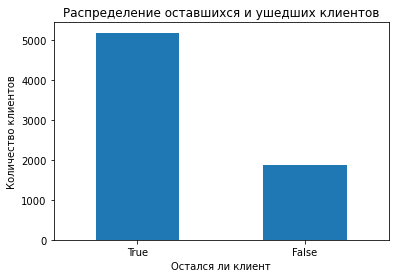

True     5174
False    1869
Name: end_date, dtype: int64

In [40]:
df.end_date.isna().value_counts().plot(kind='bar', rot=0)
plt.xlabel('Остался ли клиент')
plt.ylabel('Количество клиентов')
plt.title('Распределение оставшихся и ушедших клиентов')
plt.show()
df.end_date.isna().value_counts()

Только 73.5% заключивших договор остались клиентами оператора. 

Данный признак является целевым - наша цель прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

#### Даты заключения и расторжения контрактов

Посмотрим на даты заключения и расторжения контрактов.

In [41]:
print(f'Контракты заключались с даты: {df.begin_date.min()} по дату {df.begin_date.max()}')

Контракты заключались с даты: 2013-10-01 00:00:00 по дату 2020-02-01 00:00:00


In [42]:
print(f'Контракты расторгались с даты: {df.end_date.min()} по дату {df.end_date.max()}')

Контракты расторгались с даты: 2019-10-01 00:00:00 по дату 2020-01-01 00:00:00


Нам известно, что информация о договорах актуальна на 1 февраля 2020. 
С учетом того, что договоры в таблице заключались с 2013 года, а расторгаться начали только с 2019 года, можно сделать предположение, что для клиентов что-то изменилось и им стало не выгодно сотрудничество.

#### Типы заключаемых договоров

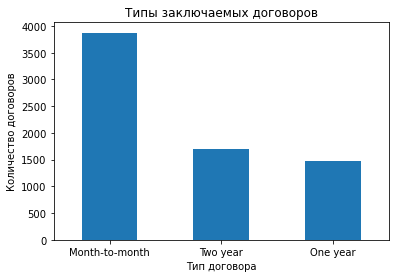

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [43]:
df.type.value_counts().plot(kind='bar', rot=0)
plt.title('Типы заключаемых договоров')
plt.ylabel('Количество договоров')
plt.xlabel('Тип договора')
plt.show()
df.type.value_counts()

Самым популярным договором является помесячный. Договор на два года немного популярнее догова на один год.

**Связь с целевым признаком**

Создадим функцию `leave_stay` для вывода, сколько клиентов какой категории ушли или остались пользоваться услугами оператора.

In [44]:
def leave_stay(column):
    print('Остались:')
    print(df[df.end_date.isna()][column].value_counts())
    print()
    print('Ушли:')
    print(df[~df.end_date.isna()][column].value_counts())

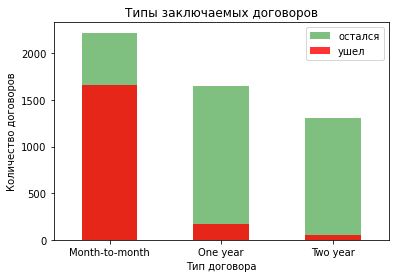

Остались:
Month-to-month    2220
Two year          1647
One year          1307
Name: type, dtype: int64

Ушли:
Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64


In [45]:
df[df.end_date.isna()].type.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].type.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.title('Типы заключаемых договоров')
plt.ylabel('Количество договоров')
plt.xlabel('Тип договора')
plt.legend()
plt.show()
leave_stay('type')

Видим, что большинство ушедших клиентов имели помесячную оплату.

#### Возможность получения электронного чека

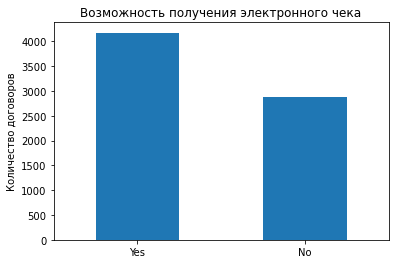

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

In [46]:
df.paperless_billing.value_counts().plot(kind='bar', rot=0)
plt.title('Возможность получения электронного чека')
plt.ylabel('Количество договоров')
plt.show()
df.paperless_billing.value_counts()

Большинство пользователей имеют возможность (получают?) электронный чек.

**Связь с целевым признаком**

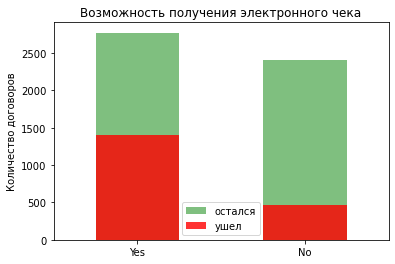

Остались:
Yes    2771
No     2403
Name: paperless_billing, dtype: int64

Ушли:
Yes    1400
No      469
Name: paperless_billing, dtype: int64


In [47]:
df[df.end_date.isna()].paperless_billing.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].paperless_billing.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')

plt.title('Возможность получения электронного чека')
plt.ylabel('Количество договоров')
plt.legend()
plt.show()
leave_stay('paperless_billing')

Видим, что процент ушедших клиентов выше среди получавших электронный чек.

#### Способ оплаты

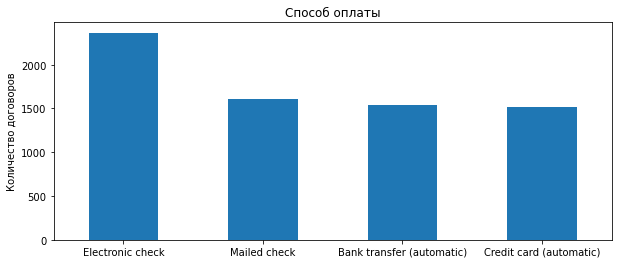

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

In [48]:
df.payment_method.value_counts().plot(kind='bar', rot=0, figsize=(10, 4))
plt.title('Способ оплаты')
plt.ylabel('Количество договоров')
plt.show()
df.payment_method.value_counts()

Электронный перевод самый популярный тип оплаты услуг оператора. 
Самостроятельные методы оплаты клиентом преобладают над автоматическими списаниями. 

В таблицу на основании имеющихся данных можно добавить маркер автоматического платежа.

In [49]:
df['is_payment_auto'] = df['payment_method'].str.endswith('(automatic)')

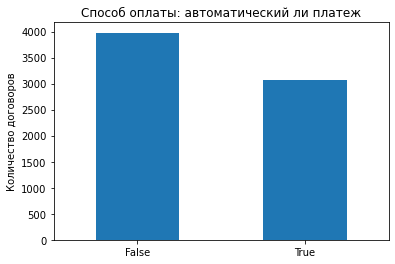

False    3977
True     3066
Name: is_payment_auto, dtype: int64

In [50]:
df.is_payment_auto.value_counts().plot(kind='bar', rot=0)
plt.title('Способ оплаты: автоматический ли платеж')
plt.ylabel('Количество договоров')
plt.show()
df.is_payment_auto.value_counts()

Больше половины пользователей не пользуются автоматическим списанием средств.

**Связь с целевым признаком**


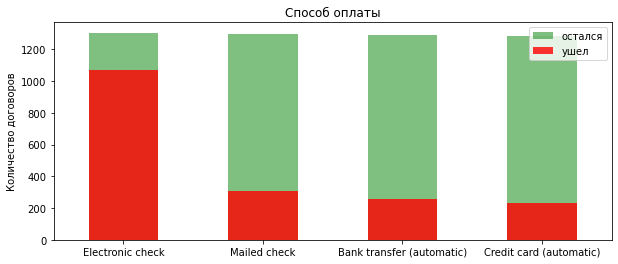

Остались:
Mailed check                 1304
Electronic check             1294
Credit card (automatic)      1290
Bank transfer (automatic)    1286
Name: payment_method, dtype: int64

Ушли:
Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: payment_method, dtype: int64


In [51]:
df[df.end_date.isna()].payment_method.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался', figsize=(10, 4))
df[~df.end_date.isna()].payment_method.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')

plt.title('Способ оплаты')
plt.ylabel('Количество договоров')
plt.legend()
plt.show()

leave_stay('payment_method')

Среди ушедших клиентов преобладают те, кто использовали электронный перевод в качестве способа оплаты.

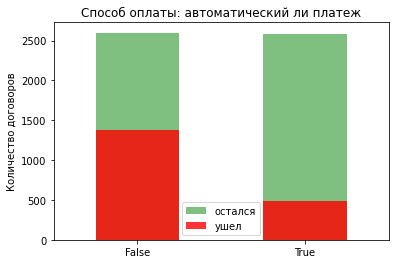

Остались:
False    2598
True     2576
Name: is_payment_auto, dtype: int64

Ушли:
False    1379
True      490
Name: is_payment_auto, dtype: int64


In [52]:
df[df.end_date.isna()].is_payment_auto.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].is_payment_auto.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')

plt.title('Способ оплаты: автоматический ли платеж')
plt.ylabel('Количество договоров')
plt.legend()
plt.show()

leave_stay('is_payment_auto')

Очевидно, что здесь распределение согласуется с графиком выше: большая часть ушедших клиентов оплачивала счета самостоятельно (не в автоматическом режиме).


#### Помесячные и общие расходы

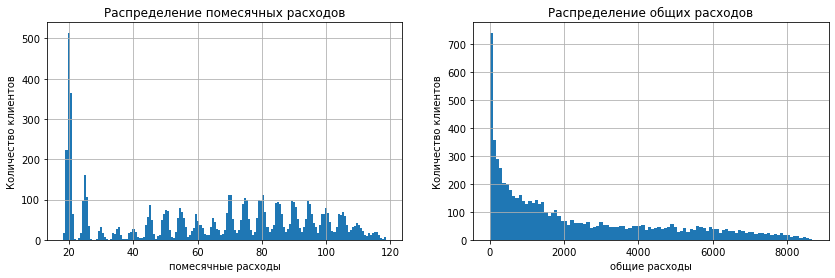

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
df.monthly_charges.hist(bins=159, ax=axes[0])
df.total_charges.hist(bins=100, ax=axes[1])
axes[0].set_title('Распределение помесячных расходов')
axes[1].set_title('Распределение общих расходов')
axes[0].set_xlabel('помесячные расходы')
axes[1].set_xlabel('общие расходы')
axes[0].set_ylabel('Количество клиентов')
axes[1].set_ylabel('Количество клиентов')

plt.show()

На распределении помесячных расходов видны множественные куполы распределения, возможно, клиенты платят фиксированную сумму за определенные услуги, и при этом немного доплачивают за остальные.

Распределение общих расходов имеет максимальные значения на минимальных суммах. Возможно, удалось привлечь новых клиентов за последнее время.

**Связь с целевым признаком**


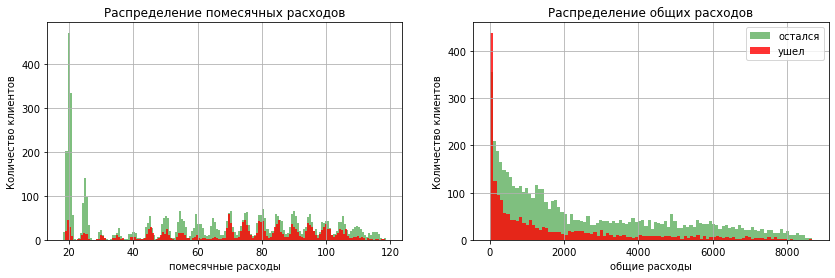

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
df[df.end_date.isna()].monthly_charges.hist(bins=159, ax=axes[0], alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].monthly_charges.hist(bins=159, ax=axes[0], alpha=0.8, color='r', label='ушел')

df[df.end_date.isna()].total_charges.hist(bins=100, ax=axes[1], alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].total_charges.hist(bins=100, ax=axes[1], alpha=0.8, color='r', label='ушел')

axes[0].set_title('Распределение помесячных расходов')
axes[1].set_title('Распределение общих расходов')
axes[0].set_xlabel('помесячные расходы')
axes[1].set_xlabel('общие расходы')
axes[0].set_ylabel('Количество клиентов')
axes[1].set_ylabel('Количество клиентов')
plt.legend()
plt.show()

Среди ушедшх клиентов преобладали помесячные расходы выше среднего, однако пик распределения общих расходов в минимальных значениях указывает на то, что клиент вскоре отказался от услуг оператора.

#### Пол клиента

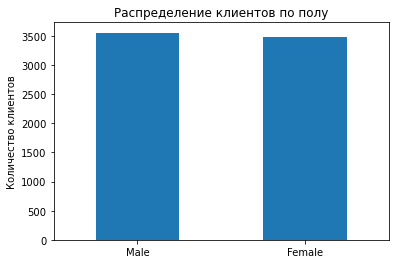

Male      3555
Female    3488
Name: gender, dtype: int64

In [55]:
df.gender.value_counts().plot(kind='bar', rot=0)
plt.title('Распределение клиентов по полу')
plt.ylabel('Количество клиентов')
plt.show()
df.gender.value_counts()

Среди клиентов почти одинаковое распределение мужчин и женщин, количество мужчин незначительно преобладает.

**Связь с целевым признаком**


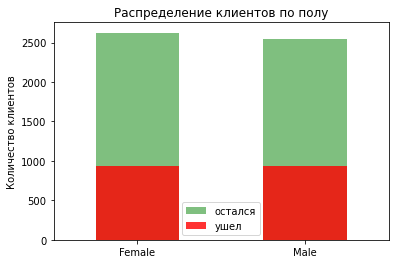

Остались:
Male      2625
Female    2549
Name: gender, dtype: int64

Ушли:
Female    939
Male      930
Name: gender, dtype: int64


In [56]:
df[df.end_date.isna()].gender.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].gender.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.title('Распределение клиентов по полу')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

leave_stay('gender')

Среди клиентов от услуг оператора отказвывались одинаково что женщины, что мужчины.

#### Пенсионер ли клиент

Посмотрим, как выглядят данные в данной колонке.

In [57]:
df.senior_citizen.unique()

array([0, 1], dtype=int64)

Скорее всего, имелись ввиду булевы значения, является или нет клиент пенсионером, поэтому для наглядности лучше заменить их на `True` и `False`.

In [58]:
df['senior_citizen'] = df['senior_citizen'] == 1

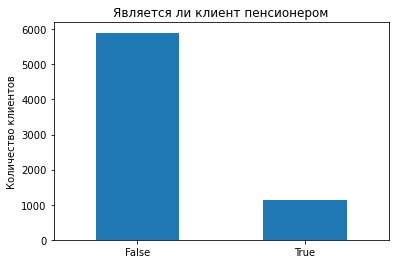

False    5901
True     1142
Name: senior_citizen, dtype: int64

In [59]:
df.senior_citizen.value_counts().plot(kind='bar', rot=0)
plt.title('Является ли клиент пенсионером')
plt.ylabel('Количество клиентов')
plt.show()
df.senior_citizen.value_counts()

Клиенты не пенсионного возраста преобладают.

**Связь с целевым признаком**

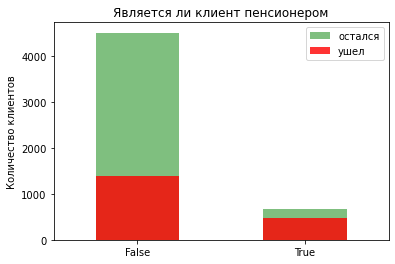

Остались:
False    4508
True      666
Name: senior_citizen, dtype: int64

Ушли:
False    1393
True      476
Name: senior_citizen, dtype: int64


In [60]:
df[df.end_date.isna()].senior_citizen.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].senior_citizen.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.title('Является ли клиент пенсионером')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

leave_stay('senior_citizen')

Большая доля пенсионеров предпочли отказаться от услуг оператора.

#### Состоит ли клиент в официальных отношениях

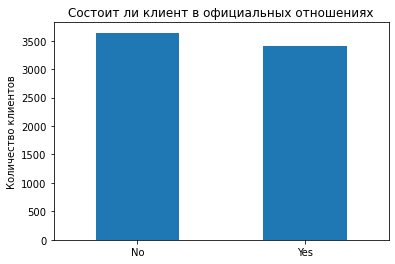

No     3641
Yes    3402
Name: partner, dtype: int64

In [61]:
df.partner.value_counts().plot(kind='bar', rot=0)
plt.title('Состоит ли клиент в официальных отношениях')
plt.ylabel('Количество клиентов')
plt.show()
df.partner.value_counts()

Распределение одиноких и семейных клиентов почти одинаковое с небольшим преобладанием одиноких клиентов.

**Связь с целевым признаком**


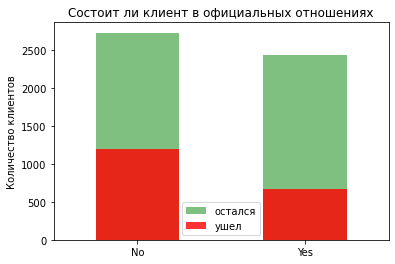

Остались:
Yes    2733
No     2441
Name: partner, dtype: int64

Ушли:
No     1200
Yes     669
Name: partner, dtype: int64


In [62]:
df[df.end_date.isna()].partner.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].partner.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')

plt.title('Состоит ли клиент в официальных отношениях')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

leave_stay('partner')

Среди ушедших преобладают свободные клиенты.

#### Есть ли у клиента иждивенцы

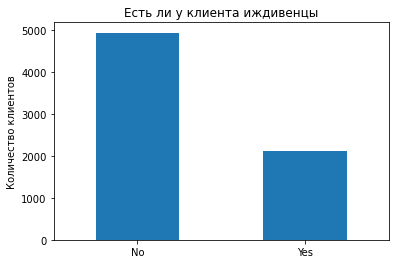

No     4933
Yes    2110
Name: dependents, dtype: int64

In [63]:
df.dependents.value_counts().plot(kind='bar', rot=0)
plt.title('Есть ли у клиента иждивенцы')
plt.ylabel('Количество клиентов')
plt.show()
df.dependents.value_counts()

Большинство клиентов не имеет иждивенцев.

**Связь с целевым признаком**


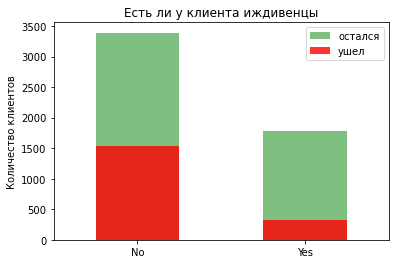

Остались:
No     3390
Yes    1784
Name: dependents, dtype: int64

Ушли:
No     1543
Yes     326
Name: dependents, dtype: int64


In [64]:
df[df.end_date.isna()].dependents.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].dependents.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.title('Есть ли у клиента иждивенцы')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()
leave_stay('dependents')

Среди клиентов с иждивенцами меньший процент отказавшихся от услуг оператора.

#### Тип подключения интернета

Интернетом пользовались не все клиенты оператора. Поэтому сначала мы будем рассматривать только тех клиентов, которые использовали интернет, но для **связи с целевым признаком** для наглядности будем смотреть на всех клиентов, включая тех, кто интернетом не пользовался.

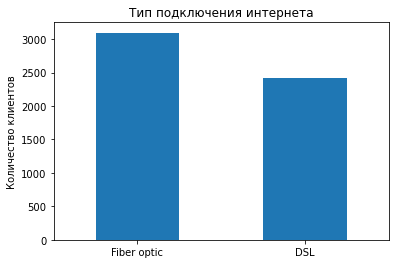

Fiber optic    3096
DSL            2421
not_used       1526
Name: internet_service, dtype: int64

In [65]:
df[df.online_backup != 'not_used'].internet_service.value_counts().plot(kind='bar', rot=0)
plt.title('Тип подключения интернета')
plt.ylabel('Количество клиентов')
plt.show()
df.internet_service.value_counts()

Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Большая часть клиентов, использующих интернет, является пользователями оптоволоконного кабеля.

**Связь с целевым признаком**

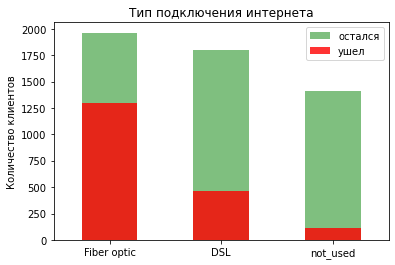

Остались:
DSL            1962
Fiber optic    1799
not_used       1413
Name: internet_service, dtype: int64

Ушли:
Fiber optic    1297
DSL             459
not_used        113
Name: internet_service, dtype: int64


In [66]:
df[df.end_date.isna()].internet_service.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].internet_service.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Тип подключения интернета')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('internet_service')

Пользователи оптоволоконных кабелей чаще всего отказывались быть клиентами оператора.

#### Облачное хранилище файлов для резервного копирования данных

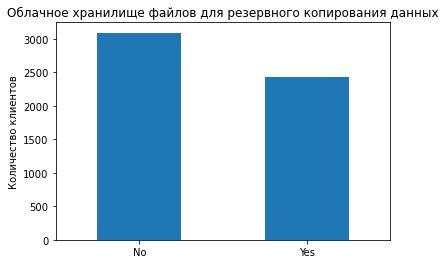

No     3088
Yes    2429
Name: online_backup, dtype: int64

In [67]:
df[df.online_backup != 'not_used'].online_backup.value_counts().plot(kind='bar', rot=0)
plt.title('Облачное хранилище файлов для резервного копирования данных')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].online_backup.value_counts()

Облачное хранилище файлов используют меньше половины пользователей интернета.

**Связь с целевым признаком**

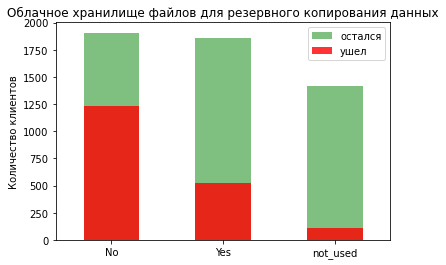

Остались:
Yes         1906
No          1855
not_used    1413
Name: online_backup, dtype: int64

Ушли:
No          1233
Yes          523
not_used     113
Name: online_backup, dtype: int64


In [68]:
df[df.end_date.isna()].online_backup.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].online_backup.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()

plt.title('Облачное хранилище файлов для резервного копирования данных')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('online_backup')

Среди клиентов, не пользовавшихся облачным хранилищем файлов для резервного копирования данных, очень много отказавшихся от услуг оператора. Возможно, необходимость переносить данные с облачного хранилища немного останавливает клиентов отказываться от услуг.

#### Интернет-безопасность: блокировка небезопасных сайтов

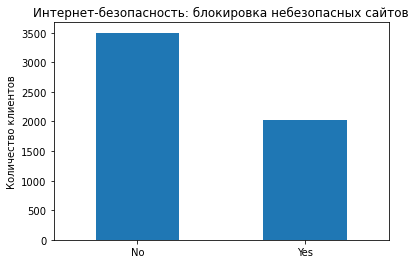

No     3498
Yes    2019
Name: online_security, dtype: int64

In [69]:
df[df.online_backup != 'not_used'].online_security.value_counts().plot(kind='bar', rot=0)
plt.title('Интернет-безопасность: блокировка небезопасных сайтов')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].online_security.value_counts()

Чуть больше трети пользователей интернета пользуются услугой блокировки небезопасных сайтов.

**Связь с целевым признаком**

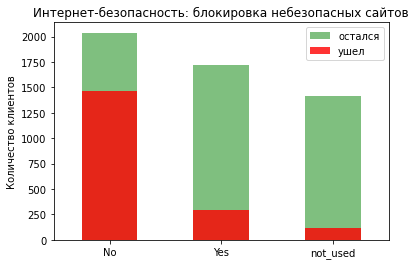

Остались:
No          2037
Yes         1724
not_used    1413
Name: online_security, dtype: int64

Ушли:
No          1461
Yes          295
not_used     113
Name: online_security, dtype: int64


In [70]:
df[df.end_date.isna()].online_security.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].online_security.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Интернет-безопасность: блокировка небезопасных сайтов')
plt.ylabel('Количество клиентов')
plt.show()

leave_stay('online_security')

Среди пользователей, не блокирующих небезопасные сайты, очень высокая доля отказавшихся от услуг оператора.

#### Интернет-безопасность: антивирус

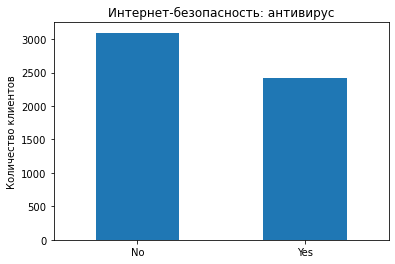

No     3095
Yes    2422
Name: device_protection, dtype: int64

In [71]:
df[df.online_backup != 'not_used'].device_protection.value_counts().plot(kind='bar', rot=0)
plt.title('Интернет-безопасность: антивирус')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].device_protection.value_counts()

Чуть менее половины пользователей интернета (44%) пользуются услугой антивируса.

**Связь с целевым признаком**

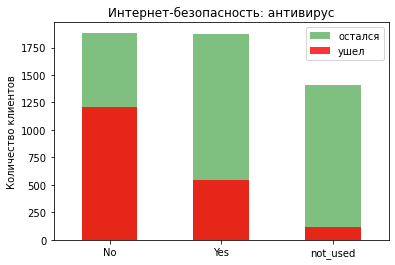

Остались:
No          1884
Yes         1877
not_used    1413
Name: device_protection, dtype: int64

Ушли:
No          1211
Yes          545
not_used     113
Name: device_protection, dtype: int64


In [72]:
df[df.end_date.isna()].device_protection.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].device_protection.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Интернет-безопасность: антивирус')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('device_protection')

Пользователи, не устанавливающие услугу антивируса, чаще уходили от оператора.

#### Выделенная линия технической поддержки

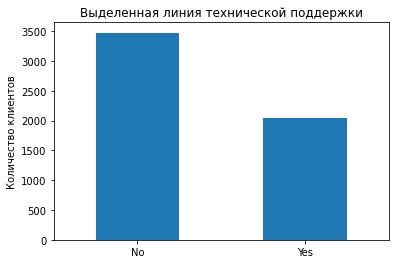

No     3473
Yes    2044
Name: tech_support, dtype: int64

In [73]:
df[df.online_backup != 'not_used'].tech_support.value_counts().plot(kind='bar', rot=0)
plt.title('Выделенная линия технической поддержки')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].tech_support.value_counts()

37% пользователей интернета предпочли пользоваться выделенной линией технической поддержки.

**Связь с целевым признаком**

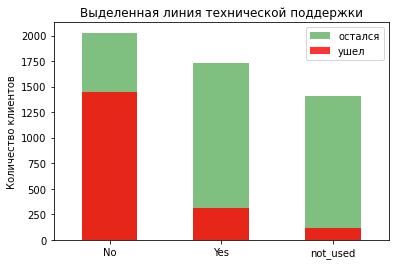

Остались:
No          2027
Yes         1734
not_used    1413
Name: tech_support, dtype: int64

Ушли:
No          1446
Yes          310
not_used     113
Name: tech_support, dtype: int64


In [74]:
df[df.end_date.isna()].tech_support.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].tech_support.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Выделенная линия технической поддержки')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('tech_support')

Чаще уходили клиенты, не использующие услугу выделенной линии технической поддержки.

#### Стриминговое телевидение 

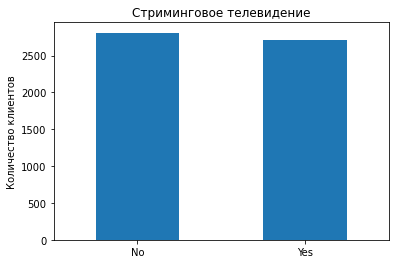

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

In [75]:
df[df.online_backup != 'not_used'].streaming_tv.value_counts().plot(kind='bar', rot=0)
plt.title('Стриминговое телевидение')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].streaming_tv.value_counts()

Чуть меньше половины клиентов пользуются услугой стримингового телевидения.

**Связь с целевым признаком**

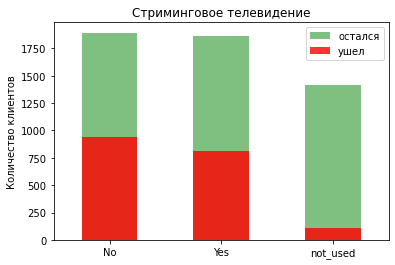

Остались:
Yes         1893
No          1868
not_used    1413
Name: streaming_tv, dtype: int64

Ушли:
No          942
Yes         814
not_used    113
Name: streaming_tv, dtype: int64


In [76]:
df[df.end_date.isna()].streaming_tv.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].streaming_tv.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Стриминговое телевидение')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('streaming_tv')

Распределение ушедших от оператора пользователей не показало связи с наличием услуги стримингового телевидения.

#### Каталог фильмов

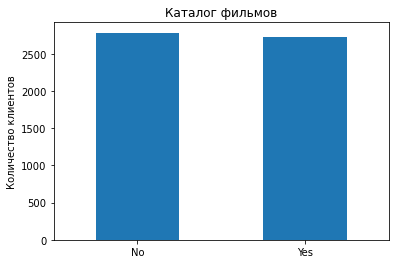

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

In [77]:
df[df.online_backup != 'not_used'].streaming_movies.value_counts().plot(kind='bar', rot=0)
plt.title('Каталог фильмов')
plt.ylabel('Количество клиентов')
plt.show()
df[df.online_backup != 'not_used'].streaming_movies.value_counts()

Чуть меньше половины пользователей пользуются данной услугой.

**Связь с целевым признаком**

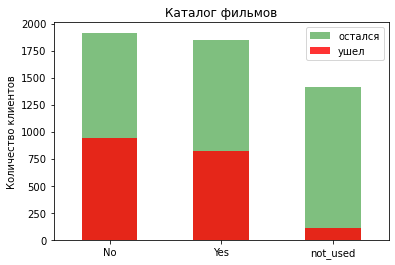

Остались:
Yes         1914
No          1847
not_used    1413
Name: streaming_movies, dtype: int64

Ушли:
No          938
Yes         818
not_used    113
Name: streaming_movies, dtype: int64


In [78]:
df[df.end_date.isna()].streaming_movies.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].streaming_movies.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Каталог фильмов')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('streaming_movies')

Распределение ушедших от оператора пользователей не показало связи с наличием услуги каталога фильмов.

#### Подключение телефонного аппарата к нескольким линиям одновременно

Телефонией пользовались не все клиенты оператора. Поэтому сначала мы будем рассматривать только тех клиентов, которые использовали телефонию, но для **связи с целевым признаком** для наглядности будем смотреть на всех клиентов, включая тех, кто телефонией не пользовался.

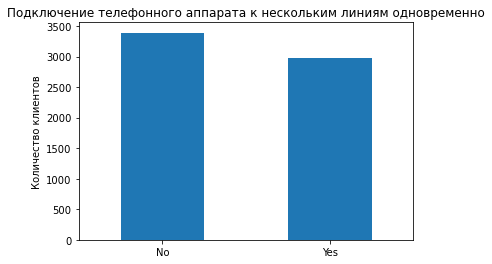

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [79]:
df[df.multiple_lines != 'not_used'].multiple_lines.value_counts().plot(kind='bar', rot=0)
plt.title('Подключение телефонного аппарата к нескольким линиям одновременно')
plt.ylabel('Количество клиентов')
plt.show()
df[df.multiple_lines != 'not_used'].multiple_lines.value_counts()

Телефонные аппараты чуть меньше половины пользователей подключены к нескольким линиям одновременно.

**Связь с целевым признаком**

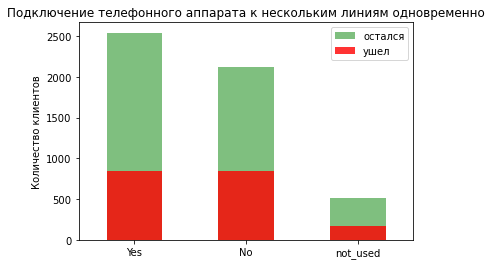

Остались:
No          2541
Yes         2121
not_used     512
Name: multiple_lines, dtype: int64

Ушли:
Yes         850
No          849
not_used    170
Name: multiple_lines, dtype: int64


In [80]:
df[df.end_date.isna()].multiple_lines.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='g', label='остался')
df[~df.end_date.isna()].multiple_lines.value_counts().plot(kind='bar', rot=0, alpha=0.8, color='r', label='ушел')
plt.legend()
plt.title('Подключение телефонного аппарата к нескольким линиям одновременно')
plt.ylabel('Количество клиентов')
plt.show()
leave_stay('multiple_lines')

Среди пользователей, не подключавших телефонный аппарат к нескольким линиям одновременно доля отказавшихся от услуг оператора немного выше.

#### **Выводы**

Таким образом, **сопоставив целевой признак с остальными признаками**, можно выявить следующие **отличительные признаки клиента**, который с большей вероятностью **прекратит пользоваться услугами оператора**:
- предпочитает помесячную оплату услуг
- предпочитает электронные чеки
- предпочитает электронные переводы
- имеет статус пенсионера 
- не имеет иждивенцев
- *интернет:* использовал оптоволоконный кабель
- *интернет:* не использовал:
    - облачное хранилице
    - услуги по интернет-безопасности
    - выделенную линию технической поддержки

### Обучение моделей

#### Подготовка к обучению моделей

Нашей задачей является прогнозировать отток клиентов. 

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия, чтобы удержать его. 

Таким образом, наша модель будет **моделью классификации**: предсказать по данным, ушел пользователь или нет. 

**Целевой признак `client_left`** для обучения моделей будет основан на колонке `end_date`: если в колонке стоит дата расторжения договора, то пользователь предпочел уйти. Саму колонку с `end_date` удаляем, так как иначе это прямая утечка признака.

Так же можем создать дополнительный признак, как **длительность использованием клиентом услуг оператора** (от заключения договора до его расторжения, либо на дату выгрузки данных (в нашем случае `1 февраля 2020 года`).

Так как мы рассчитываем прогнозировать отток **действующих** клиентов, могли бы использовать для получения данного признака просто разницу между датами. (Если модель планируется использоваться на других данных, то для подсчета длительности можно было бы брать актуальную дату и вычитать дату заключения договора.) 

<!-- КОНЦЕПЦИЮ ПОМЕНЯЛА, А БЫЛО: В то же самое время у нас есть две колонки с затратами, что позволяет получить количество месяцев, сколько клиент пользуется услугами оператора, простым делением колонки с общими затратами пользователя `total_charges` на колонку с помесячными затратами пользователя `monthly_charges`. Это избавляет нас от необходимости думать о датах, что предпочтительнее. -->

Таким образом, в таблице мы будем иметь дату заключения договора и длительность жизни клиента. Кажется, что это будет непрямой утечкой данных. Если дата + длительность жизни клиента не равны 1 февраля 2020 года, то очевидно, что клиент ушел. Для исключения такой возможности, было решено **убрать дату заключения договора из датасета**.

Так же уникальный код клиента нам не нужен для обучения модели. 

In [81]:
df['lifetime'] = pd.to_datetime(df['end_date'].where(~df['end_date'].isna(), '2020-02-01')) - df['begin_date']
df['lifetime'] = df['lifetime'].dt.days
df['client_left'] = (~df['end_date'].isna())
df.drop(['end_date', 'begin_date', 'customer_id'], axis=1, inplace=True)

Взглянем на получившийся датасет.

In [82]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_payment_auto,lifetime,client_left
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,not_used,False,31,False
1,One year,No,Mailed check,56.95,1889.50,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,False,1036,False
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,False,61,True
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,not_used,True,1371,False
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,False,61,True


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   bool   
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

Разделим данные на признаки и целевой признак.


In [84]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_payment_auto,lifetime,client_left
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,not_used,False,31,False
1,One year,No,Mailed check,56.95,1889.50,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,False,1036,False
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,False,61,True
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,not_used,True,1371,False
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,False,61,True


In [85]:
# признаки
features = df.drop('client_left', axis=1)
# целевой признак
target = df['client_left'].astype('int8')

Разобъем данные на тренировочную, валидационную и тестовую выборки в пропорциях 3:1:1. Для начала отделим 20% данных под тестовую выборку `..._test`.

In [86]:
features_df, features_test, target_df, target_test = train_test_split(
    features, 
    target, 
    test_size=0.2,
    random_state=STATE,
    shuffle=True
)

Для некоторых моделей нам понадобится валидационная выборка, для некоторых будем использовать кросс-валидацию.
Поэтому теперь отделим от выборок `..._df` 25% под валидационную `..._valid` и остальное под обучающую `..._train`.

In [87]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df,
    target_df,
    test_size=0.25,
    random_state=STATE,
    shuffle=True
)

Посмотрим на размеры выборок.


In [88]:
features_train.shape, features_valid.shape, features_test.shape

((4225, 19), (1409, 19), (1409, 19))

Пропорция 3:1:1 соблюдена.


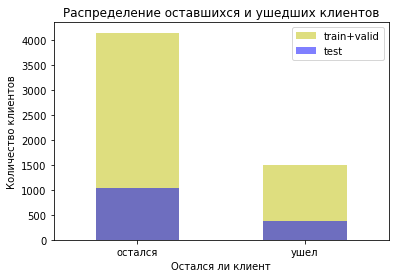

In [89]:
target_df.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='y', label='train+valid')
target_test.value_counts().plot(kind='bar', rot=0, alpha=0.5, color='b', label='test')

plt.xlabel('Остался ли клиент')
plt.ylabel('Количество клиентов')
plt.title('Распределение оставшихся и ушедших клиентов')
plt.xticks([0, 1], ['остался', 'yшел'])
plt.legend()
plt.show()

Распределение целевого признака в тестовой выборке адекватное.

#### Кодирование категориальных и масштабирование численных признаков

В колонках `monthly_charges`, `total_charges` и `charges_time` содержится числовая информация, которую для машинного обучения мы масштабируем.

В остальных колонках содержится строковая или булева информация, которую для машинного обучения нужно кодировать.

Разобъем данные на категориальные и числовые признаки.


Для кодировки категориальных признаков мы используем технику прямого кодирования `One-Hot Encoding`.

Для стандартизации числовых признаков мы используем `StandardScaler`.

In [90]:
numeric_to_scaler = [column for column in features.columns if features[column].dtype in ['float64', 'int64']]
categorical_to_ohe = [column for column in features.columns if features[column].dtype not in ['float64', 'int64']]

In [91]:
numeric_to_scaler, categorical_to_ohe

(['monthly_charges', 'total_charges', 'lifetime'],
 ['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'senior_citizen',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines',
  'is_payment_auto'])

In [92]:
df.lifetime.dtypes

dtype('int64')

Проверим числовые признаки на мультиколлинеарность.

In [93]:
df[numeric_to_scaler].corr()

,monthly_charges,total_charges,lifetime
monthly_charges,1.000000,0.651174,0.247754
total_charges,0.651174,1.000000,0.826109
lifetime,0.247754,0.826109,1.000000


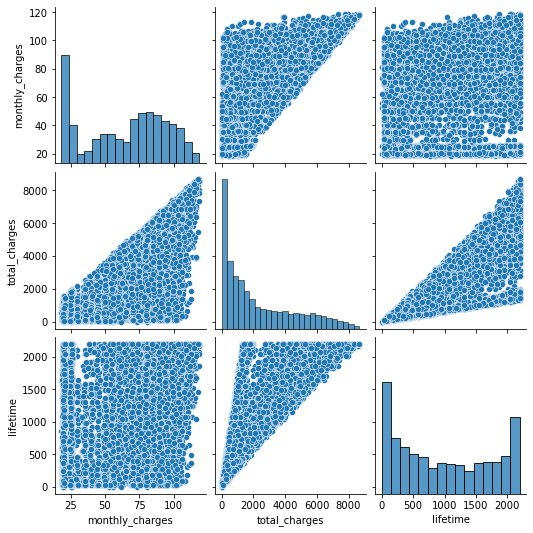

In [94]:
sns.pairplot(df[numeric_to_scaler], diag_kind="hist")
plt.show()

Признаков с линейной корреляцией выше 0.9 не обнаружено.

Далее создадим объет класса `ColumnTransformer`, чтобы объединить различные методы обработки признаков.

In [95]:
ct =  make_column_transformer(
    (StandardScaler(), numeric_to_scaler),
    (OneHotEncoder(), categorical_to_ohe)
)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['monthly_charges', 'total_charges',
                                  'lifetime']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['type', 'paperless_billing', 'payment_method',
                                  'gender', 'senior_citizen', 'partner',
                                  'dependents', 'internet_service',
                                  'online_security', 'online_backup',
                                  'device_protection', 'tech_support',
                                  'streaming_tv', 'streaming_movies',
                                  'multiple_lines', 'is_payment_auto'])])

#### Оценка адекватности моделей

Для обучения моделей нам понадобится оценить качество прогноза. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия, однако важно не предлагать их тем, кто итак планировал остаться. Таким образом, нам важно оценить влияние ошибки как первого, так и второго рода. 

Для оценки качества моделей будем использовать `AUC-ROC` с оглядкой на `accuracy`.
`AUC-ROC` изменяется от 0 до 1. `AUC-ROC` случайной модели равно 0.5.

Для оценки адекватности моделей так же можем использовать `DummyClassifier`, предсказывающий наиболее частое значениео целевого признака обучающей выборки.


In [96]:
dummy = DummyClassifier(
    strategy = 'most_frequent', 
    random_state = STATE
    )
dummy.fit(features_train, target_train)

acc_dummy = dummy.score(features_valid, target_valid)
print(f'Метрики на baseline-модели:\naccuracy: {acc_dummy:.3}')

Метрики на baseline-модели:
accuracy: 0.749


Создадим табличку, в которую будем добавлять результаты обучения моделей.

In [97]:
results = pd.DataFrame(columns=['valid_AUC_ROC', 'valid_accuracy'])
results.loc['dummy', 'valid_AUC_ROC'] = 0.500
results.loc['dummy', 'valid_accuracy'] = acc_dummy.round(3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749


Далее мы планируем обучить несколько моделей и выбрать из них показавшую самые высокие метрики качества.

#### **Важное отсупление**
В рамках данной работы сразу сделаем важное отступление:

- Модели иногда считаются достаточно медленно, поэтому в каждой модели были перебраны разные гиперпараметры, которые впоследствии в коде были сокращены для увеличения скорости отработки тетради.

- Гиперпараметры, которые я подбирала или пыталась прикрутить/привинтить, оставляю обычно закомментированными, чтобы можно было оценить, что я делала в рамках проекта.

#### Линейные модели: логистическая регрессия

Построим пайплайн для логистической регрессии.

In [98]:
%%time

pipe_lr = Pipeline([
    ('column_transformer', ct),
    ('model', LogisticRegression()),

])

params_lr = [
    {
        'model': [LogisticRegression()],
#         'model__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:2}, None],
        'model__class_weight': [None],
        'model__n_jobs': [-1],
        'model__random_state': [STATE],
#         'model__C': np.logspace(-3,3,7), # before
        'model__C': [10.0], # after
#         'model__penalty': [
#                            'elasticnet', 
#                            'l1', 
#                            'l2', 
#                            'none'
#                            ], # before
        'model__penalty': ['l2'], # after
        'model__max_iter': [1000000]

    },
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=STATE)

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=params_lr,
    cv=cv,
    n_jobs=-1,
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    return_train_score=True,
    verbose=2
)

grid_lr.fit(features_df, target_df)

lr_model = grid_lr.best_estimator_

lr_auc_roc = grid_lr.best_score_
print('Best Params:', grid_lr.best_params_)
print()
print('Best AUC-ROC Score:', lr_auc_roc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'model': LogisticRegression(C=10.0, max_iter=1000000, n_jobs=-1, random_state=12345), 'model__C': 10.0, 'model__class_weight': None, 'model__max_iter': 1000000, 'model__n_jobs': -1, 'model__penalty': 'l2', 'model__random_state': 12345}

Best AUC-ROC Score: 0.8460122966381709
Wall time: 7.34 s


Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [99]:
acc_lr = float(grid_lr.cv_results_['mean_test_accuracy'].mean())
acc_lr

0.8051118210862619

Добавим метрики в итоговую таблицу.

In [100]:
results.loc['Logistic Regression', 'valid_AUC_ROC'] = lr_auc_roc.round(3)
results.loc['Logistic Regression', 'valid_accuracy'] = round(acc_lr, 3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749
Logistic Regression,0.846,0.805


#### Линейные модели: метод опорных векторов

Построим пайплайн для модели линейных опорных векторов.

In [101]:
%%time

pipe_svc = Pipeline([
    ('column_transformer', ct),
    ('model', LinearSVC()),


])

params_svc = [
    {    
        'model': [LinearSVC()],
        # 'model__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:2}, None],
        'model__class_weight': [{0:1, 1:3}],
        'model__random_state': [STATE],
        # 'model__C': np.logspace(-3,3,7),
        'model__C': [1.0], # after
        # 'model__penalty': ['l1', 'l2'],
        'model__penalty': ['l2'],
        'model__max_iter': [10000],
        'model__tol': [1e-10]

    },
]

grid_svc = GridSearchCV(
    pipe_svc,
    param_grid=params_svc,
    cv=cv,
    n_jobs=-1,
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    return_train_score=True,
    verbose=3
)

grid_svc.fit(features_df, target_df)

svc_model = grid_svc.best_estimator_


svc_auc_roc = grid_svc.best_score_
print('Best Params:', grid_svc.best_params_)
print()
print('Best AUC-ROC Score:', svc_auc_roc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'model': LinearSVC(class_weight={0: 1, 1: 3}, max_iter=10000, random_state=12345,
          tol=1e-10), 'model__C': 1.0, 'model__class_weight': {0: 1, 1: 3}, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 12345, 'model__tol': 1e-10}

Best AUC-ROC Score: 0.845030225145861
Wall time: 8.4 s


Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [102]:
acc_svc = float(grid_svc.cv_results_['mean_test_accuracy'].mean())
acc_svc

0.7335818246361377

Добавим метрики в итоговую таблицу.

In [103]:
results.loc['SVC', 'valid_AUC_ROC'] = svc_auc_roc.round(3)
results.loc['SVC', 'valid_accuracy'] = round(acc_svc, 3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749
Logistic Regression,0.846,0.805
SVC,0.845,0.734


#### Модель случайного леса

Построим пайплайн для модели случайного леса.


In [104]:
pipe_forest = Pipeline([
    ('column_transformer', ct),
    ('model', RandomForestClassifier())

])

params_forest = [
    {
        'model': [RandomForestClassifier()],
#         'model__n_estimators': list(range(1, 200, 10)), # параметры при подборе
#         'model__n_estimators': list(range(170, 181)), # параметры при подборе  
        'model__n_estimators': [181], # параметры после подбора

#         'model__max_depth': list(range(2, 20)), # параметры при подборе
        'model__max_depth': [7], # параметры после подбора
        'model__random_state': [STATE],
        'model__n_jobs': [-1],


    },
]

grid_forest = GridSearchCV(
    pipe_forest,
    param_grid=params_forest,
    cv=cv,
    n_jobs=-1,
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    return_train_score=True,
    verbose=3
)

grid_forest.fit(features_df, target_df)

forest_model = grid_forest.best_estimator_


forest_auc_roc = grid_forest.best_score_
print('____________________________________________________________________________________')
print('Best Params:', grid_forest.best_params_)
print()
print('Bes AUC-ROC Score:', forest_auc_roc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
____________________________________________________________________________________
Best Params: {'model': RandomForestClassifier(max_depth=7, n_estimators=181, n_jobs=-1,
                       random_state=12345), 'model__max_depth': 7, 'model__n_estimators': 181, 'model__n_jobs': -1, 'model__random_state': 12345}

Bes AUC-ROC Score: 0.8564823522142976


Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [105]:
acc_forest = float(grid_forest.cv_results_['mean_test_accuracy'].mean())
acc_forest

0.8123890663826767

Добавим метрики в итоговую таблицу.

In [106]:
results.loc['Random Forest', 'valid_AUC_ROC'] = forest_auc_roc.round(3)
results.loc['Random Forest', 'valid_accuracy'] = round(acc_forest, 3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749
Logistic Regression,0.846,0.805
SVC,0.845,0.734
Random Forest,0.856,0.812


#### Модель градиентного бустинга библиотеки LightGBM

##### с внутренней обработкой категориальных признаков

Обучим модель градиентного бустинга библиотеки LightGBM с внутренней обработкой категориальных признаков. Для этого заменим все нечисловые признаки на категориальные.

In [107]:
features_train_gb = features_train.copy(deep=True)
features_valid_gb = features_valid.copy(deep=True)
features_test_gb = features_test.copy(deep=True)
features_df_gb = features_df.copy(deep=True)

for feature in categorical_to_ohe:
    features_train_gb[feature] = pd.Series(features_train_gb[feature], dtype="category")
    features_valid_gb[feature] = pd.Series(features_valid_gb[feature], dtype="category")
    features_test_gb[feature] = pd.Series(features_test_gb[feature], dtype="category")
    features_df_gb[feature] = pd.Series(features_df_gb[feature], dtype="category")

In [108]:
pipe_light_category = Pipeline([
    ('model', LGBMClassifier())

])

params_light_category = [
    {
        'model': [LGBMClassifier()],
#         'model__n_estimators': list(range(1, 300, 10)), # параметры при подборе
#         'model__n_estimators': list(range(290, 500, 10)), # параметры при подборе
#         'model__n_estimators': list(range(490, 500)), # параметры при подборе        
        'model__n_estimators': [498], # параметры после подбора

#         'model__max_depth': list(range(2, 20, 1)), # параметры при подборе
#         'model__max_depth': list(range(2, 10, 1)), # параметры при подборе
        'model__max_depth': [3], # параметры после подбора
        'model__random_state': [STATE],
        'model__n_jobs': [-1],
#         'model__objective': ['binary']


    },
]

grid_light_category = GridSearchCV(
    pipe_light_category, 
    param_grid=params_light_category, 
    cv=cv, 
    n_jobs=-1, 
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc', 
    return_train_score=True, 
    verbose=2
)

grid_light_category.fit(features_df_gb, target_df, model__categorical_feature='auto')

ligth_cat_model = grid_light_category.best_estimator_


light_auc_roc_categories = grid_light_category.best_score_
print('Best Params:', grid_light_category.best_params_)
print()
print('Best AUC-ROC Score:', light_auc_roc_categories)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'model': LGBMClassifier(max_depth=3, n_estimators=498, random_state=12345), 'model__max_depth': 3, 'model__n_estimators': 498, 'model__n_jobs': -1, 'model__random_state': 12345}

Best AUC-ROC Score: 0.9018356043824817


Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [109]:
acc_light_categ = float(grid_light_category.cv_results_['mean_test_accuracy'].mean())
acc_light_categ

0.851792687255946

Добавим метрики в итоговую таблицу.


In [110]:
results.loc['LGBM with categories', 'valid_AUC_ROC'] = light_auc_roc_categories.round(3)
results.loc['LGBM with categories', 'valid_accuracy'] = round(acc_light_categ, 3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749
Logistic Regression,0.846,0.805
SVC,0.845,0.734
Random Forest,0.856,0.812
LGBM with categories,0.902,0.852


##### с обработкой категориальных признаков One-Hot-Encoder

Обучим модель градиентного бустинга библиотеки LightGBM с обработкой категориальных признаков `One-Hot-Encoder`. 

In [111]:
pipe_light = Pipeline([
    ('column_transformer', ct),
    ('model', LGBMClassifier())

])

params_light = [
    {
        'model': [LGBMClassifier()],
#         'model__n_estimators': list(range(1, 300, 10)), # параметры при подборе
#         'model__n_estimators': list(range(290, 500, 10)), # параметры при подборе
        'model__n_estimators': list(range(490, 500)), # параметры при подборе


        'model__n_estimators': [493], # параметры после подбора

#         'model__max_depth': list(range(2, 20, 1)), # параметры при подборе
#         'model__max_depth': list(range(2, 10, 1)), # параметры при подборе
        'model__max_depth': [3], # параметры после подбора
        'model__random_state': [STATE],
        'model__n_jobs': [-1],
    },
]

grid_light = GridSearchCV(
    pipe_light, 
    param_grid=params_light, 
    cv=cv, 
    n_jobs=-1, 
    scoring=['roc_auc', 'accuracy'], 
    refit='roc_auc', 
    return_train_score=True, 
    verbose=2
)


grid_light.fit(features_df, target_df)

light_model = grid_light.best_estimator_


light_auc_roc = grid_light.best_score_
print('Best Params:', grid_light.best_params_)
print()
print('Best AUC-ROC Score:', light_auc_roc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'model': LGBMClassifier(max_depth=3, n_estimators=493, random_state=12345), 'model__max_depth': 3, 'model__n_estimators': 493, 'model__n_jobs': -1, 'model__random_state': 12345}

Best AUC-ROC Score: 0.9027121381720363


Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [112]:
acc_light = float(grid_light.cv_results_['mean_test_accuracy'])
acc_light

0.8558750443734469

Добавим метрики в итоговую таблицу.

In [113]:
results.loc['LGBM with OHE', 'valid_AUC_ROC'] = light_auc_roc.round(3)
results.loc['LGBM with OHE', 'valid_accuracy'] = round(acc_light, 3)
results

,valid_AUC_ROC,valid_accuracy
dummy,0.5,0.749
Logistic Regression,0.846,0.805
SVC,0.845,0.734
Random Forest,0.856,0.812
LGBM with categories,0.902,0.852
LGBM with OHE,0.903,0.856


#### Модель градиентного бустинга библиотеки CatBoost

Обучим модель градиентного бустинга библиотеки `CatBoost` с внутренней обработкой категориальных признаков.

In [114]:
cat_boost = CatBoostClassifier()
params_cb = {
#     'iterations': [500, 1000, 1500],
    'iterations': [1000],
#     'depth': [4, 5, 6],
    'depth': [5],
#     'loss_function': ['Logloss', 'CrossEntropy'],
    'loss_function': ['Logloss'],
#     'l2_leaf_reg': np.logspace(-20, -19, 3),
    'l2_leaf_reg': [3.162277660168379e-20],
#     'leaf_estimation_iterations': [10],
#     'eval_metric': ['roc_auc'],
#     'use_best_model': ['True'],
      'logging_level':['Silent'],
      'random_seed': [STATE]
    }

grid_cat_boost = GridSearchCV(
    estimator=cat_boost,
    param_grid=params_cb,
    cv=cv,
    scoring=['roc_auc', 'accuracy'], 
    refit='roc_auc',
    return_train_score=True,
    verbose=50
)
grid_cat_boost.fit(features_df_gb, target_df, cat_features=categorical_to_ohe)

cat_boost_model = grid_cat_boost.best_estimator_


cat_boost_auc_roc = grid_cat_boost.best_score_
print('Best Params:', grid_cat_boost.best_params_)
print()
print('Best AUC-ROC Score:', cat_boost_auc_roc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START depth=5, iterations=1000, l2_leaf_reg=3.162277660168379e-20, logging_level=Silent, loss_function=Logloss, random_seed=12345
[CV 1/3; 1/1] END depth=5, iterations=1000, l2_leaf_reg=3.162277660168379e-20, logging_level=Silent, loss_function=Logloss, random_seed=12345; accuracy: (train=0.927, test=0.856) roc_auc: (train=0.970, test=0.897) total time=  31.3s
[CV 2/3; 1/1] START depth=5, iterations=1000, l2_leaf_reg=3.162277660168379e-20, logging_level=Silent, loss_function=Logloss, random_seed=12345
[CV 2/3; 1/1] END depth=5, iterations=1000, l2_leaf_reg=3.162277660168379e-20, logging_level=Silent, loss_function=Logloss, random_seed=12345; accuracy: (train=0.922, test=0.864) roc_auc: (train=0.970, test=0.910) total time=  33.2s
[CV 3/3; 1/1] START depth=5, iterations=1000, l2_leaf_reg=3.162277660168379e-20, logging_level=Silent, loss_function=Logloss, random_seed=12345
[CV 3/3; 1/1] END depth=5, iterations=1000,

Кросс-валидацией нашли лучшую модель. Теперь достанем из параметров значение метрики качества `accuracy`.

In [115]:
acc_cat_boost = float(grid_cat_boost.cv_results_['mean_test_accuracy'].mean())
acc_cat_boost

0.8603123890663827

Добавим метрики в итоговую таблицу.

In [116]:
results.loc['CatBoost', 'valid_AUC_ROC'] = cat_boost_auc_roc.round(3)
results.loc['CatBoost', 'valid_accuracy'] = round(acc_cat_boost, 3)
results = results.sort_values('valid_AUC_ROC', ascending=False)
results

,valid_AUC_ROC,valid_accuracy
CatBoost,0.904,0.86
LGBM with OHE,0.903,0.856
LGBM with categories,0.902,0.852
Random Forest,0.856,0.812
Logistic Regression,0.846,0.805
SVC,0.845,0.734
dummy,0.5,0.749


Визуализируем итоговые значения метрик.

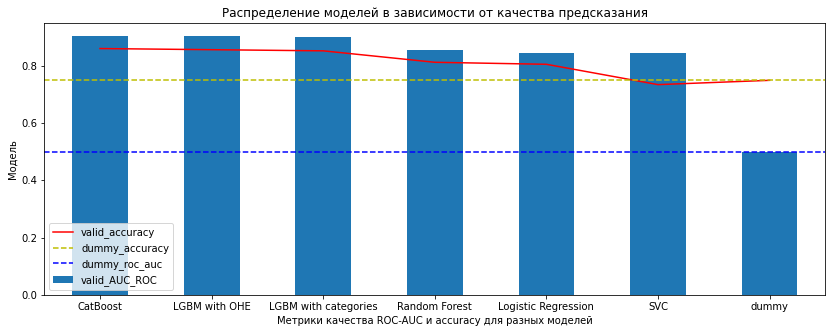

In [117]:
results['valid_accuracy'].plot(kind='line', c='r', linestyle='-', figsize=(14, 5))
results['valid_AUC_ROC'].plot(kind='bar', rot=0)
plt.ylabel('Модель')
plt.xlabel('Метрики качества ROC-AUC и accuracy для разных моделей')
plt.title('Распределение моделей в зависимости от качества предсказания')
plt.axhline(y=acc_dummy.round(3), color='y', linestyle='--', label='dummy_accuracy')
plt.axhline(y=0.5, color='b', linestyle='--', label='dummy_roc_auc')

plt.legend()
plt.show()

- Значения метрики ROC-AUC у всех моделей выше случайного угадывания.
- Значения метрики accuracy у модели опорных векторов оказалось ниже, чем у константной модели, предсказывающей наиболее встречаемый класс.


- Градиентные бустинги показали наивысшие значения метрик, лучше всех обучилась модель библиотеки `CatBoost`. 

- На втором месте по качеству - модель случайного леса.
- На третьем - линейные модели. Модель логистической регрессии в данной задаче показала себя лучше модели линейных опорных векторов.

#### Стекинг

Итак, у нас есть 4 модели, на которых можно попробовать стекинг, или ансамбль смешивания:
- градиентные бустинги двух разных библиотек
- случайный лес
- логистическая регрессия

Метод опорных векторов показал себя не очень хорошо, а еще он не поддерживает метод `predict_proba`, поэтому уберем его из стекинга.

In [118]:
estimators = [
    ('log_regr', lr_model),
    ('random_forest', forest_model),
    ('light', light_model),
]

stacking = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    stack_method = 'predict_proba',
    cv=cv,
    n_jobs=-1
)
stacking.fit(features_train, target_train)
probabilities_one_valid = stacking.predict_proba(features_valid)[:, 1]
auc_roc_stacking = roc_auc_score(target_valid, probabilities_one_valid)
acc_stacking = accuracy_score(target_valid, stacking.predict(features_valid))
print('AUC-ROC:', auc_roc_stacking)
print('accuracy:', acc_stacking)

AUC-ROC: 0.8867915164391793
accuracy: 0.8523775727466288


In [119]:
results.loc['Stacking', 'valid_AUC_ROC'] = round(auc_roc_stacking, 3)
results.loc['Stacking', 'valid_accuracy'] = round(acc_stacking, 3)
results = results.sort_values('valid_AUC_ROC', ascending=False)
results

,valid_AUC_ROC,valid_accuracy
CatBoost,0.904,0.86
LGBM with OHE,0.903,0.856
LGBM with categories,0.902,0.852
Stacking,0.887,0.852
Random Forest,0.856,0.812
Logistic Regression,0.846,0.805
SVC,0.845,0.734
dummy,0.5,0.749


Визуализируем итоговые значения метрик.

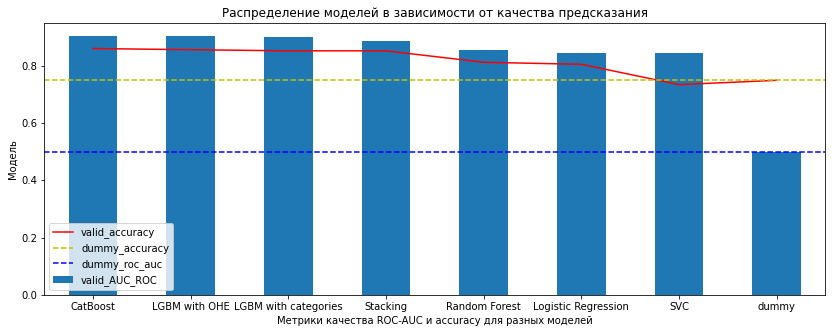

In [120]:
results['valid_accuracy'].plot(kind='line', c='r', linestyle='-', figsize=(14, 5))
results['valid_AUC_ROC'].plot(kind='bar', rot=0)
plt.ylabel('Модель')
plt.xlabel('Метрики качества ROC-AUC и accuracy для разных моделей')
plt.title('Распределение моделей в зависимости от качества предсказания')
plt.axhline(y=acc_dummy.round(3), color='y', linestyle='--', label='dummy_accuracy')
plt.axhline(y=0.5, color='b', linestyle='--', label='dummy_roc_auc')

plt.legend()
plt.show()

Стекинг в данной задаче показал себя не очень хорошо.

Для финального тестирования выбираем модель библиотеки `CatBoost`.

#### Тестирование модели

Протестируем модель библиотеки `CatBoost` на тестовой выборке.

In [121]:
auc_roc_final_train = roc_auc_score(target_df, cat_boost_model.predict_proba(features_df_gb)[:, 1])
accuracy_final_train = accuracy_score(target_df, cat_boost_model.predict(features_df_gb))
print('На обучающей выборке:')
print(f'Метрика качества ROC-AUC: {auc_roc_final_train:.3f}')
print(f'Метрика качества accuracy: {accuracy_final_train:.3f}')
print()

auc_roc_final_test = roc_auc_score(target_test, cat_boost_model.predict_proba(features_test_gb)[:, 1])
accuracy_final_test = accuracy_score(target_test, cat_boost_model.predict(features_test_gb))
print('На тестовой выборке:')
print(f'Метрика качества ROC-AUC: {auc_roc_final_test:.3f}')
print(f'Метрика качества accuracy: {accuracy_final_test:.3f}')

На обучающей выборке:
Метрика качества ROC-AUC: 0.968
Метрика качества accuracy: 0.917

На тестовой выборке:
Метрика качества ROC-AUC: 0.916
Метрика качества accuracy: 0.878


Создадим итоговую табличку.

In [122]:
test_results = pd.DataFrame(columns=['AUC_ROC', 'accuracy'])
test_results.loc['train', 'AUC_ROC'] = auc_roc_final_train
test_results.loc['test', 'AUC_ROC'] = auc_roc_final_test
test_results.loc['train', 'accuracy'] = accuracy_final_train
test_results.loc['test', 'accuracy'] = accuracy_final_test
test_results


,AUC_ROC,accuracy
train,0.967899,0.916755
test,0.915542,0.877928


Визуализируем результат тестирования модели.

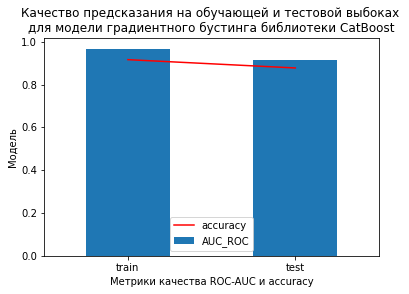

In [123]:
test_results['accuracy'].plot(kind='line', c='r', linestyle='-')

test_results['AUC_ROC'].plot(kind='bar', rot=0)

plt.ylabel('Модель')
plt.xlabel('Метрики качества ROC-AUC и accuracy')
plt.title('Качество предсказания на обучающей и тестовой выбоках \nдля модели градиентного бустинга библиотеки CatBoost')

plt.legend()
plt.show()

Метрики качества на тестовой выборке оказались чуть ниже, чем на обучающей выборке. Это говорит о небольшой переученности модели, однако она показала хорошую обобщающую способность и выдала приемлемые результаты. 

Визуализируем получившуюся ROC-кривую.

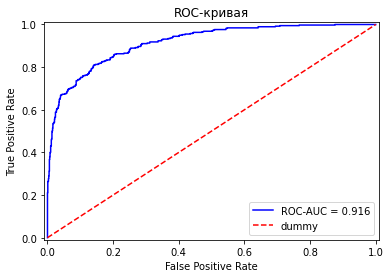

In [124]:
probs = cat_boost_model.predict_proba(features_test_gb)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(target_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC-кривая')
plt.plot(fpr, tpr, 'b', label = 'ROC-AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label='dummy')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

ROC-кривая гораздо выше случайных предсказаний (красная пунктирная линия на графике), и значения ROC-AUC не слишком далеки от идеального значения в единицу. 

Посмотрим, какие же признаки модель посчитала самыми важными.

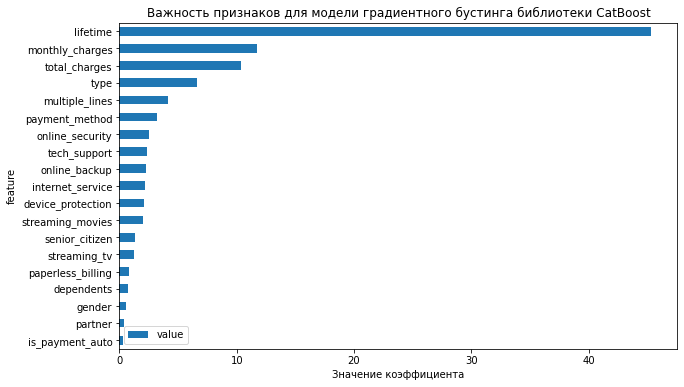

In [125]:
feature_names = cat_boost_model.feature_names_
coefs = cat_boost_model.feature_importances_

zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df = df.sort_values("value", ascending=False)
df = df.set_index('feature').sort_values('value', ascending=True)
df.plot(kind='barh', figsize=(10, 6))
plt.title('Важность признаков для модели градиентного бустинга библиотеки CatBoost')
plt.xlabel('Значение коэффициента')
plt.show()

- Признак, показавшийся модели самым значимым - время жизни клиента.
- Далее следует месячный платеж и траты за всё время
- Следом идет тип договора. 

### Вывод

Данное исследование было посвящено **прогнозу оттока клиентов у оператора связи**, чтобы при риске ухода клиента оператор смог оперативно предложить ему промокоды и специальные условия. 

Работа велась на основании персональных данных о некоторых клиентах, информации об их тарифах и договорах. 

Был проведен **исследовательский анализ данных**, который показал, что у клиента, который с большей вероятностью прекратит пользоваться услугами оператора, было несколько отличительных признаков:
- предпочитает помесячную оплату услуг
- предпочитает электронные чеки
- предпочитает электронные переводы
- имеет статус пенсионера
- не имеет иждивенцев
- интернет: использовал оптоволоконный кабель
- интернет: не использовал:
    - облачное хранилице
    - услуги по интернет-безопасности
    - выделенную линию технической поддержки

Далее для более точных прогнозов были обучены несколько моделей машинного обучения:
- линейные модели:
    - логистической регрессии
    - метод опорных векторов
- случайного леса
- градиентного бустинга:
    - библиотеки LightGBM
    - библиотеки CatBoost

По результатам обучения:
- Градиентные бустинги показали наивысшие значения метрик, лучше всех обучилась модель библиотеки CatBoost.
- На втором месте по качеству - модель случайного леса.
- На третьем - линейные модели. Модель логистической регрессии в данной задаче показала себя лучше модели линейных опорных векторов.

Для **финального тестирования** выбираем **модель библиотеки `CatBoost`** и были получены следующие результаты:

**На обучающей выборке:**
- Метрика качества `ROC-AUC`: `0.968`
- Метрика качества `accuracy`: `0.917`

**На тестовой выборке:**
- Метрика качества `ROC-AUC`: `0.916`
- Метрика качества `accuracy`: `0.878`

Модель немного переобучилась, но должна справиться с прогнозом оттока клиентов: не позволит упускать клиентов и не даст предлагать скидки и промокоды без необходимости. 

**Оценка важности признаков** для протестированной модели показала, что:
- Самый значимый для предсказания ухода признак - время жизни клиента.
- Далее следует месячный платеж и траты за всё время.
- Следом идет тип договора.

Это не совсем согласуется с выводами на основании только исследовательского анализа данных, что подтверждает необходимость использования моделей машинного обучения для выявления закономерностей в данных.
